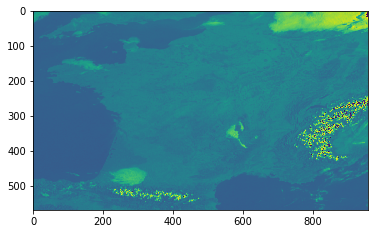

(<matplotlib.image.AxesImage at 0x7f0823e927f0>, None)

In [2]:
import cv2, pyautogui, glob, random, statistics,PIL.Image 
import numpy as np
from statistics import mode
import scipy.stats as stat
import matplotlib.pyplot as plt
from medpy.filter.smoothing import anisotropic_diffusion
from scipy.stats import moment
from sklearn import neighbors as nn
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import MeanShift, estimate_bandwidth, AgglomerativeClustering, AffinityPropagation, KMeans
imagesTif = glob.glob('tif/*.tif')# parcours de la liste de nommes d'immages
N = len(imagesTif); Images = []# tableau vide pour charger les images 
for i in range(N):# parcourir le nombre des images
    I_Base = PIL.Image.open(imagesTif[i])
    I_Base = np.asanyarray(I_Base, np.uint8)
    Images.append(I_Base)
plt.imshow(Images[100]),plt.show()

In [3]:
def seg_M1(BD, N_im, w, k, CLF):
    # k nbre des classes a initialise pour l'algo kmean 
    # N_im: nbre des images a traiter pour l'apprentissage de classification et pour la segmentation  
    # w: unite taille de la cellule(w*2+1, w*2+1) pour la classification et pour la segmentation
    # Clf: classifieur a choisir (Kmean , ou Knn)
    METHOD = 'uniform'; radius = 0.36;n_points = 6.00* radius;
    Data_Stat = []; Image = BD[N_im];
    if (np.mean(Image)<=165): 
        Image = cv2.equalizeHist(Image)# egalisation d'ihtogramme sous condition
    Image = local_binary_pattern(Image, n_points, radius, METHOD);
    Image = anisotropic_diffusion(Image, niter = 20, gamma = 0.01);
    for px in range(w, (Image.shape[0]-w), 1):# parcours des x de l'image
        for py in range(w, (Image.shape[1]-w), 1):# parcours des y de l'image 
            D_test = Image[px-w:px+w, py-w:py+w];D_test = np.ndarray.flatten(D_test)# case de donnees a analyser
            Mode = stat.mode(D_test);Nobs,MinMax,Moy,Var,SK,Ku = stat.describe(D_test)#indices stat descriptifs                
            Data_Stat.append([Moy,Var,SK,Ku,Mode[0]])
    Data_Stat = np.asarray(Data_Stat) # Data_Stat.shape ==> (n, 5) pour deux images 
    # classification (K en classes ) des donnes statistiques
    if (CLF == 1): #Kmean
        clf = KMeans(n_clusters = k, n_init=1, init='k-means++').fit(Data_Stat)# apprentissage
    elif (CLF == 2):#Knn 
        clf = MeanShift().fit(Data_Stat);
        k = len(np.unique(clf.labels_));
        print("nbre des classifieurs pour Kmean Shift", k);
    elif (CLF==3):
        clf = linkage(Data_Stat);#, 'single')
        k = len(np.unique(clf.labels_));
        print("nbre des classifieurs pour Kmean Shift", k);
    elif (CLF==4):
        clf = AgglomerativeClustering(n_clusters = k).fit_predict(Data_Stat) 
    # Segmentation#-------------------------------------------------------------------------------
    D_test_seg = []; Im = np.zeros((Image.shape[0],Image.shape[1])); # image resultat
    for px in range(w,(Image.shape[0]-w), 1):# parcours des x de l'image
        for py in range(w, (Image.shape[1]-w), 1):# parcours des y de l'image 
            D_t_Im = np.ndarray.flatten(Image[px-w:px+w, py-w:py+w]);
            Mode = stat.mode(D_t_Im); M = Mode[0]; Nobs,MinMax,Moy,Var,SK,Ku = stat.describe(D_t_Im);
            D = np.array([Moy, Var, SK, Ku, M]).reshape(1, -1);
            for i in range(k):
                if(clf.predict(D) == i):
                    Im[px-w:px+w, py-w:py+w] = round(255/abs(i+1));# coloration du case
    Im = np.asanyarray(Im, np.uint8);
    # fermeture
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (w, w))
    #Im = cv2.dilate(Im, kernel, iterations=5)
    #Im = cv2.erode(Im, kernel, iterations=5)
    plt.subplot(1,2,1),plt.imshow(BD[N_im]),plt.axis('off'),plt.gcf().set_size_inches(2*plt.gcf().get_size_inches());
    plt.subplot(1,2,2),plt.imshow(Im),plt.axis('off'),plt.gcf().set_size_inches(2*plt.gcf().get_size_inches());
    plt.show()

In [3]:
# Avec tt pretraitement et modification de fenetre de traitement

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


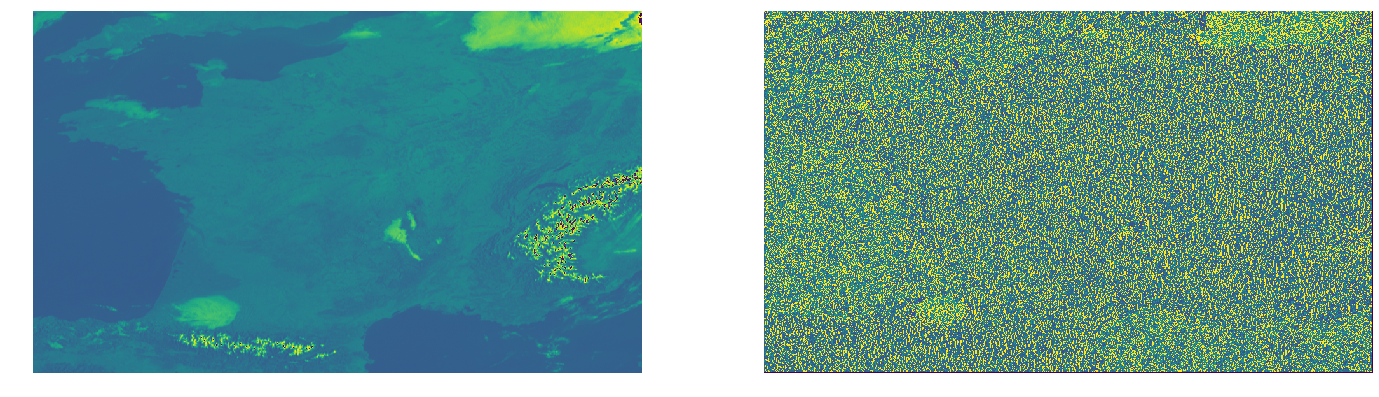

In [4]:
seg_M1(Images, N_im = 100, w = 1, k = 4, CLF = 1);

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


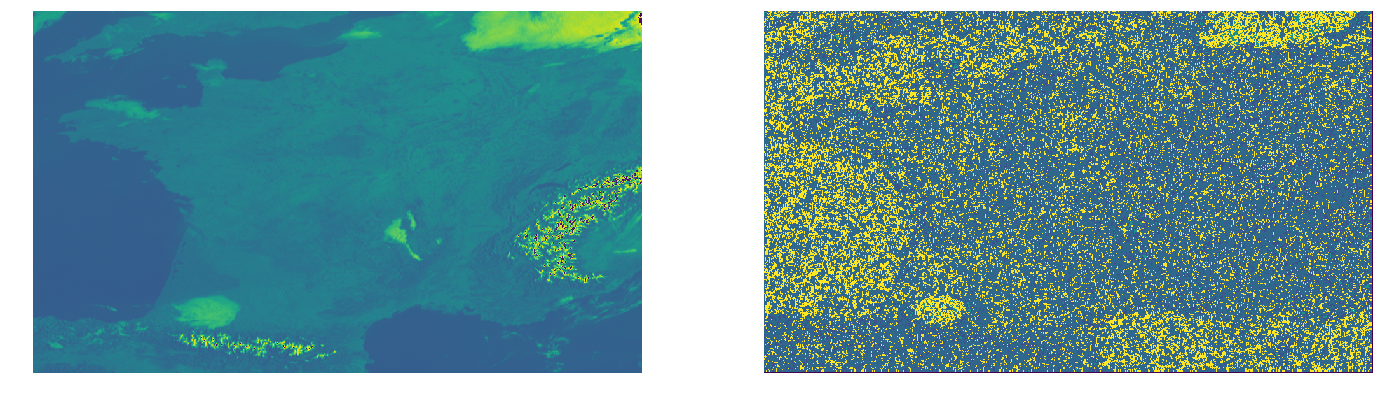

In [ ]:
seg_M1(Images, N_im = 100, w = 2, k = 4, CLF = 1);

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


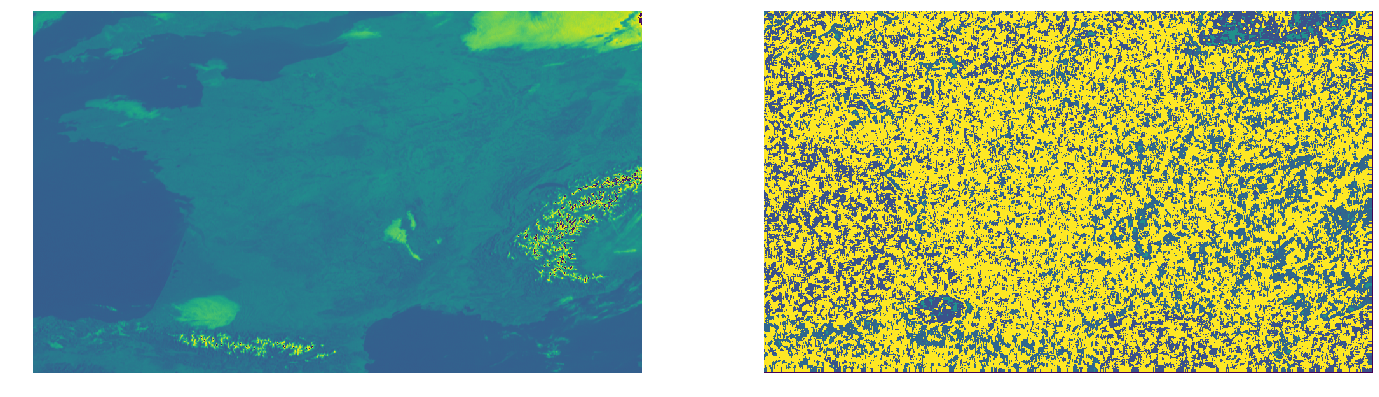

Time 3273.8315069675446


In [3]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 3, k = 4, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


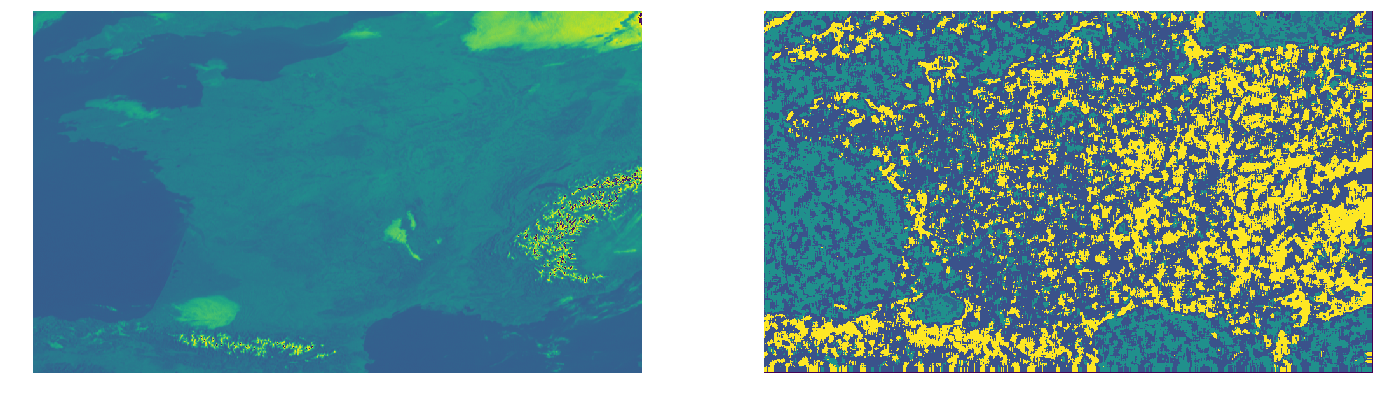

Time 3747.204672574997


In [4]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 4, k = 4, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


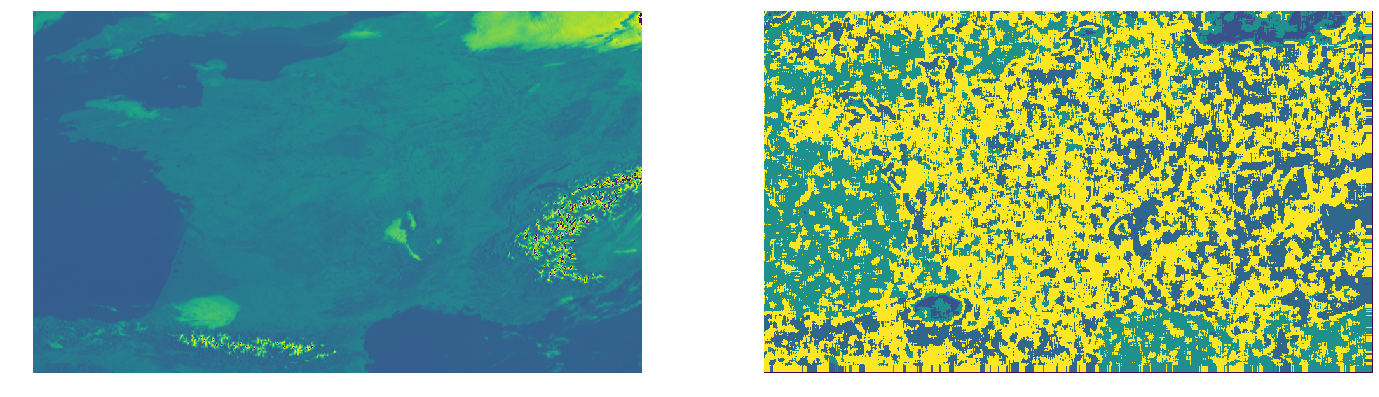

Time 5020.127204179764


In [5]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 5, k = 4, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


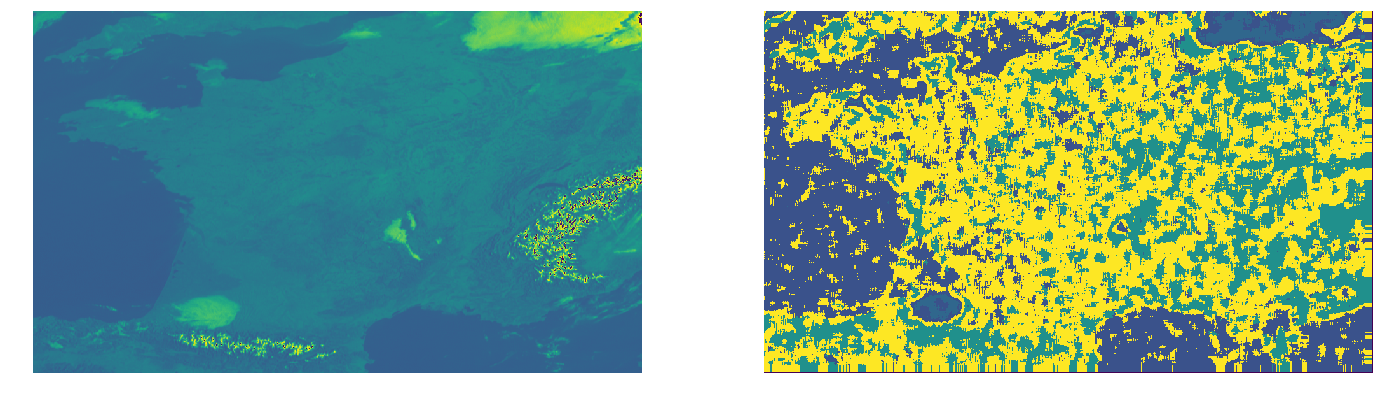

Time 34861.14603328705


In [3]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 6, k = 4, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


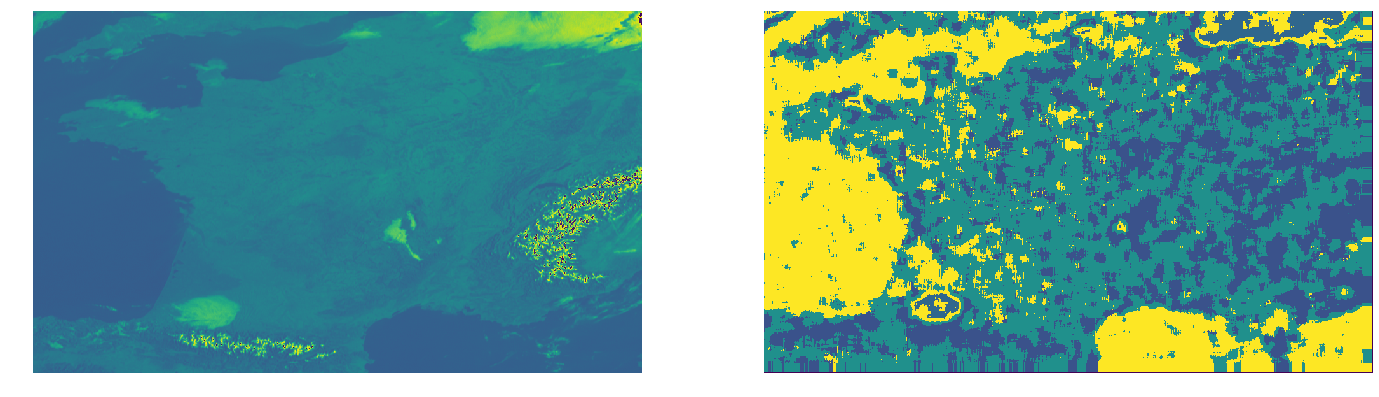

Time 2695.7830419540405


In [4]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 7, k = 4, CLF = 1);# 15*15
t2=time.time()
print('Time', t2-t1)
#

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


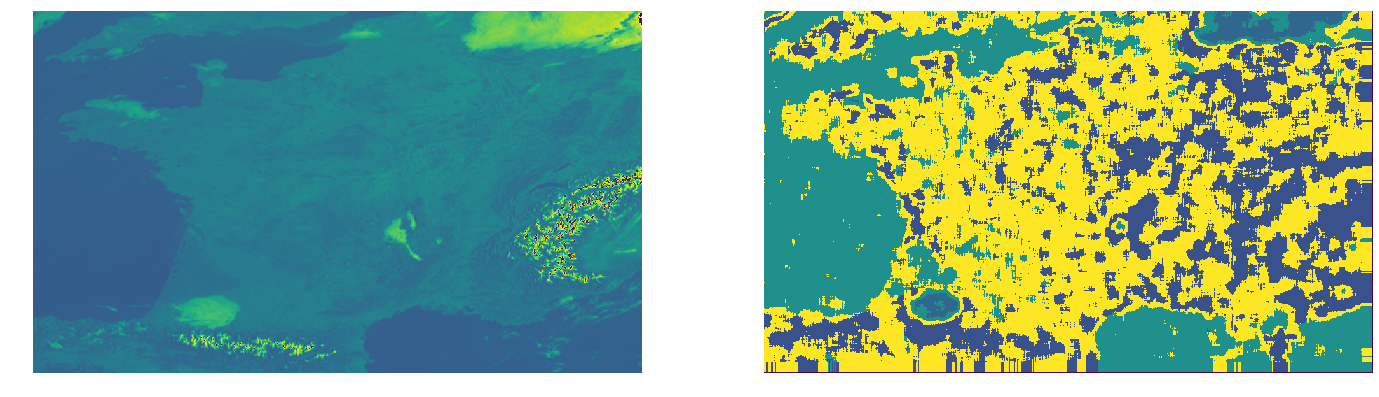

Time 2452.8884625434875


In [5]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 8, k = 4, CLF = 1);# 17*17
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


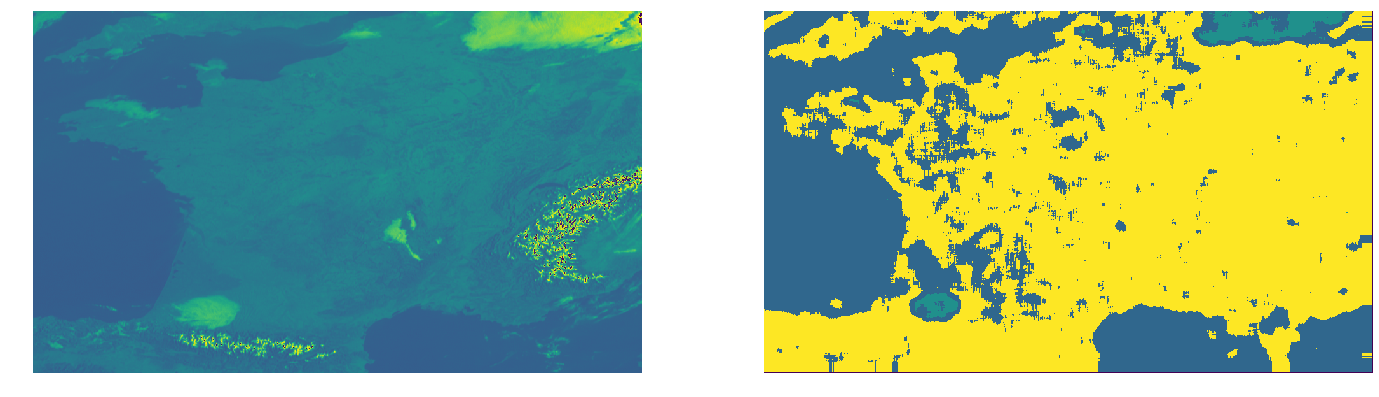

Time 2084.3127026557922


In [6]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 8, k = 3, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


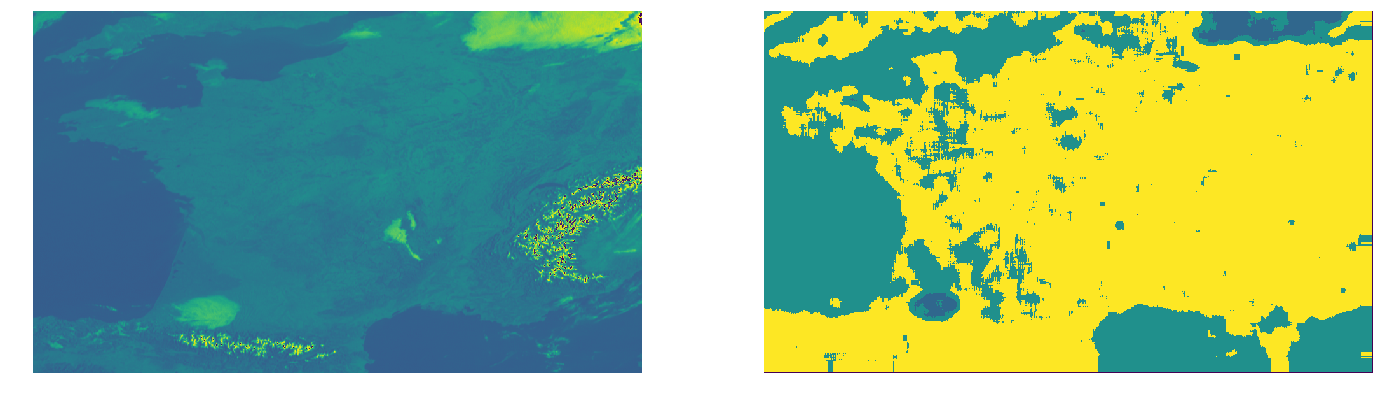

Time 2028.698893547058


In [7]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 9, k = 3, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


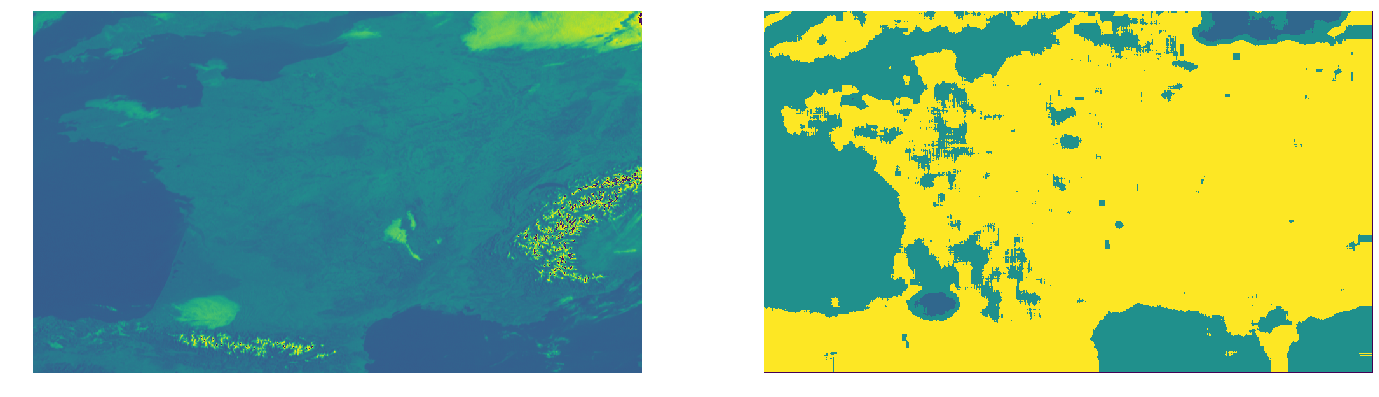

Time 2579.3284635543823


In [8]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 10, k = 3, CLF = 1);
t2=time.time()
print('Time', t2-t1)

In [1]:
2500/60

41.666666666666664

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


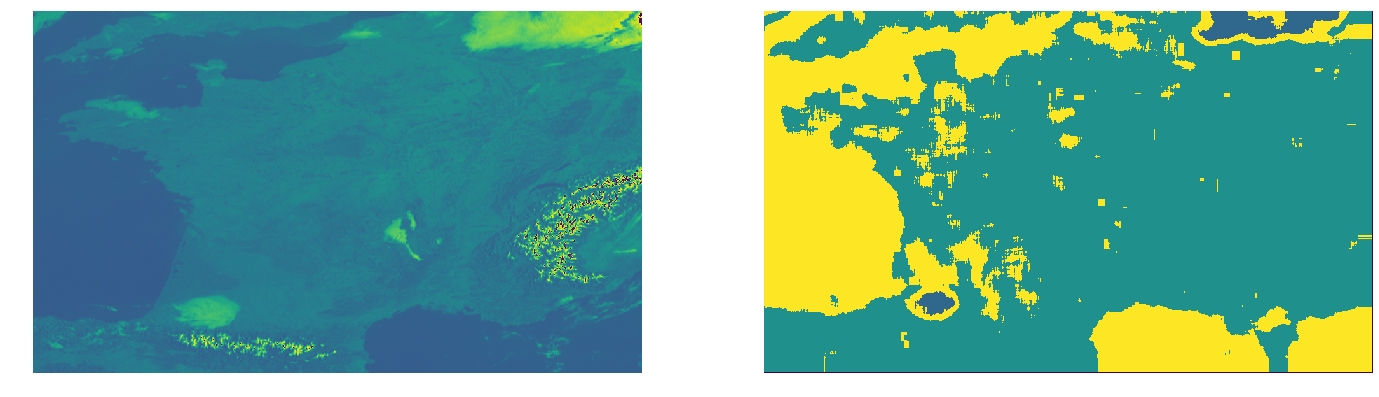

Time 2772.7283663749695


In [9]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 11, k = 3, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


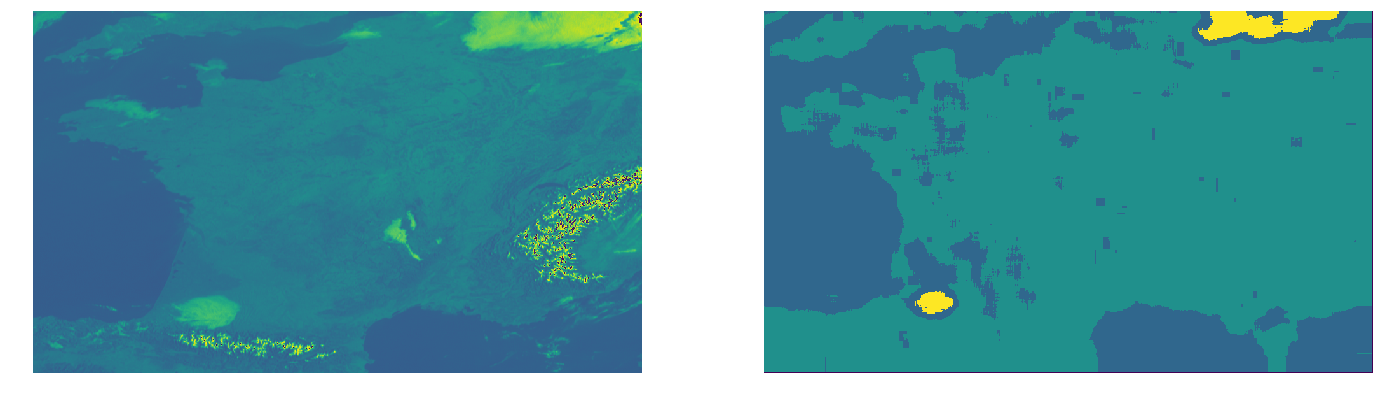

Time 2152.217431783676


In [10]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 12, k = 3, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


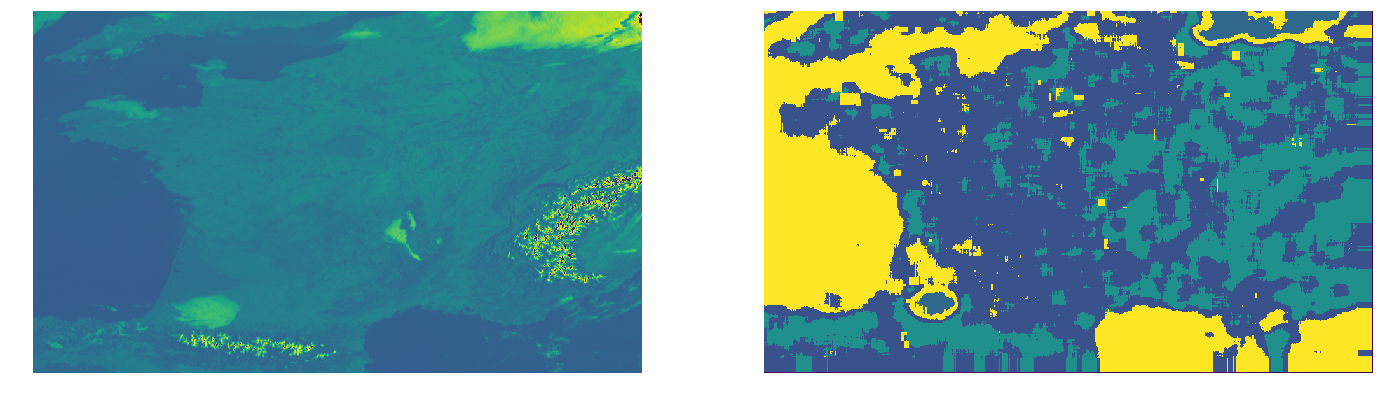

Time 2478.03693819046


In [13]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 11, k = 4, CLF = 1);
t2=time.time()
print('Time', t2-t1)

/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ls/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:151: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


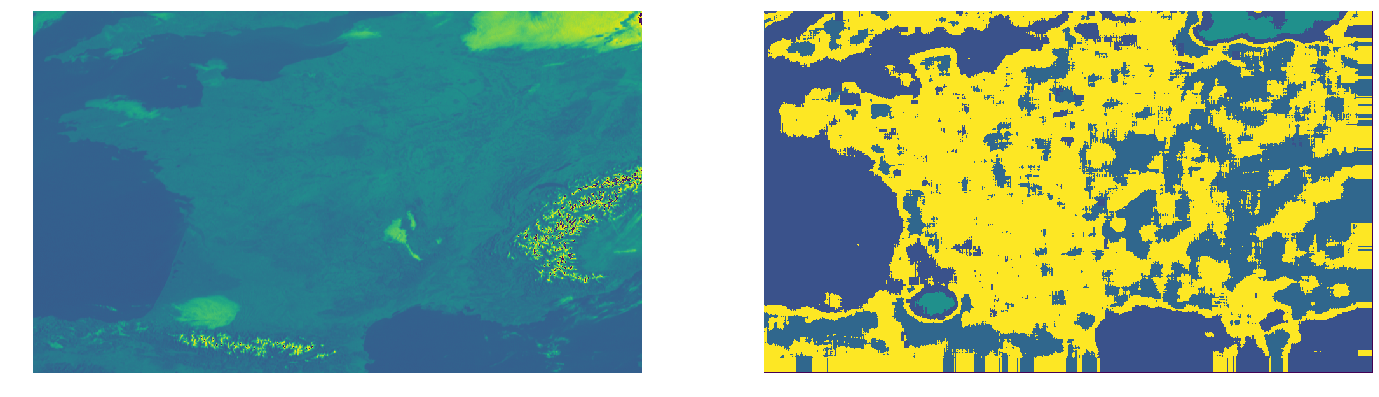

Time 2509.246701478958


In [11]:
import time
t1=time.time()
seg_M1(Images, N_im = 100, w = 11, k = 4, CLF = 1);
t2=time.time()
print('Time', t2-t1)